In [205]:
import utils
import gaussian_cal
import pandas as pd
import subprocess
import os
import time
from rdkit.Chem import PandasTools
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

name_list = ['S','A','EHOPA','AEPYridine','AEP','APN','DBE','DIPEDA','OA','mXD']
smiles_list = [
'FC1(C(F)(C(F)(F)F)F)C(OC(F)(F)C(F)1F)(C(F)(C(F)(F)F)F)F',
'FC1(C(F)(C(F)(F)F)F)C(OC(F)(F)C(F)1F)(C(F)(C(O)=O)F)F',
'CCCCC(CC)COCCCNC(C(F)(F)C1(F)OC(F)(F)C(F)(F)C1(C(F)(C(O)=O)F)F)=O',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCC2=CN=CC=C2)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCN2CCCCC2)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NC2=CC(C#N)=CC(C#N)=C2)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCN(CCCC)CCCC)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCN(C(C)C)C(C)C)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCCCCCCCC)=O)F)O1',
'FC1(F)C(F)(F)C(F)(C(F)(C(O)=O)F)C(F)(C(F)(C(NCC2=CC(CN)=CC=C2)=O)F)O1',
]
P_sp = {'S':0.135,'A':0.211,'EHOPA':0.686,'AEPYridine':0.855,'AEP':0.862,
        'APN':0.558,'DBE':0.746,'DIPEDA':0.715,'OA':0.576,'mXD':0.959,}
IP_PCM = {'EHOPA':7.38,'AEPYridine':7.63,'AEP':6.18,'APN':8.18,'DBE':6.27,
        'DIPEDA':6.21,'OA':8.15,'mXD':6.78,'S':11.32,'A':9.73,}
psp = np.array([P_sp[i] for i in name_list])
ip_pcm = np.array([IP_PCM[i] for i in name_list])


In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
def smile2xyz(xyz_name,smile):
    '''
    xyz_name: xyz file including postfixed .xyz
    smiles: smiles string
    for instance smile2xyz('CH4_0.xyz','C')
    create a CH4 folder and => dir_name
    create a CH4_0.xyz file named CH4.xyz stored in  CH4 folder
    !!! xyz file should be ended with _n.xyz, n is a index, should be 1/2.
    '''
    mol = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    # Draw.MolToImage(mol,size=(100,100))
    xyz_str = Chem.MolToXYZBlock(mol)
    dir_name = xyz_name.split('_')[0]
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    file_path = os.path.join(dir_name, xyz_name)
    with open(file_path, "w") as file:
        file.write(xyz_str)
for i in range(len(name_list)):
    for j in range(10):
        smile2xyz(name_list[i]+str(j)+'_0.xyz',smiles_list[i])

In [ ]:
G0 = gaussian_cal.GaussianCal(method='m062x',basis='6-311G(2d,p)',charge='neu',wfn=True,debug=True)
for i in range(len(name_list)):
    for j in range(10):
        if os.path.exists(f"{name_list[i]}{j}"):
            # if not utils.xyzcheck(f'{name_list[i]}{j}_0.xyz',smiles_list[i]):
            #     print(f"{name_list[
            # i]}{j}_0.xyz is not correct")
            #     continue
            while utils.i8cpu_running():
                time.sleep(60)
            G0.Run(f"{name_list[i]}{j}_0.xyz")

G1 = gaussian_cal.GaussianCal(method='m062x',basis='6-311G(2d,p)',charge='pos',wfn=True,debug=True)
for i in range(len(name_list)):
    for j in range(10):
        if os.path.exists(f"{name_list[i]}{j}"):
            # if not utils.xyzcheck(f'{name_list[i]}{j}_0.xyz',smiles_list[i]):
            #     print(f"{name_list[i]}{j}_0.xyz is not correct")
            #     continue
            while utils.i8cpu_running():
                time.sleep(60)
            G1.Run(f"{name_list[i]}{j}_0.xyz")



**Result Analysis**

In [128]:
from tqdm import tqdm

IP = []
IP_dict = {}
IP_name = []
for _ in name_list:
    for i in tqdm(range (200)):
        if os.path.exists(f"{_}{i}"):
            IP.append(float("{:.3f}".format((utils.IP_calculation((f"{_}{i}"))))))
            IP_name.append(f"{_}{i}")

100%|██████████| 200/200 [00:08<00:00, 22.90it/s]


In [161]:
table = pd.DataFrame({'Name': IP_name, 'm062x/6-311G(2d,p) IP': IP})
table.to_csv('CYTOP_m062x_6-311G(2d,p)_IP_rdkit.csv', index=False)
df = table.drop(['Name'], axis=1)
reshaped_data = df['m062x/6-311G(2d,p) IP'].values.reshape(10, 10).T
new_df = pd.DataFrame(reshaped_data, columns=[f'{name_list[i]}' for i in range(10)])
# new_df.to_csv('CYTOP_m062x_6-311G(2d,p)_IP_rdkit.csv', index=False)
rdkit_df = new_df
rdkit_df

,S,A,EHOPA,AEPYridine,AEP,APN,DBE,DIPEDA,OA,mXD
0,13.085,11.818,9.552,9.451,8.681,9.711,7.961,8.015,9.749,8.774
1,13.110,11.710,9.480,0.000,8.443,9.730,8.206,7.873,9.674,8.959
2,13.127,11.790,9.488,9.502,8.201,9.706,8.418,8.049,9.956,8.842
3,12.971,11.796,9.519,9.522,8.770,9.727,8.221,8.131,9.556,9.195
4,12.971,11.792,9.508,9.654,8.497,9.711,8.292,8.073,9.741,8.906
5,13.090,11.750,9.301,9.411,8.052,9.703,8.051,8.069,9.762,8.923
6,12.971,11.756,9.607,9.416,7.979,9.654,7.758,8.165,10.270,8.997
7,13.081,11.738,9.398,9.404,8.206,9.768,7.968,8.024,9.804,8.978
8,13.339,11.914,9.424,9.406,8.523,9.752,8.439,8.016,9.731,8.841
9,13.213,11.704,9.360,9.485,8.167,9.689,8.172,8.101,9.772,8.963


In [170]:
for i in range(10):
    random = np.array(rdkit_df.iloc[i].tolist())
    print(np.corrcoef(random,psp)[0,1])
mean = np.array(round(rdkit_df.mean(),3).tolist())
median = np.array(round(rdkit_df.median(),3).tolist())
print('mean',np.corrcoef(mean,psp)[0,1])
print('median',np.corrcoef(median,psp)[0,1])

-0.8841106292109285
-0.6595234076089758
-0.8987110011853076
-0.8652784720892467
-0.8823714864597794
-0.8895421549295603
-0.8754159053155008
-0.8826792773375508
-0.9006015714626269
-0.8856319948784686
mean -0.9176595721059414
median -0.8896199650309468


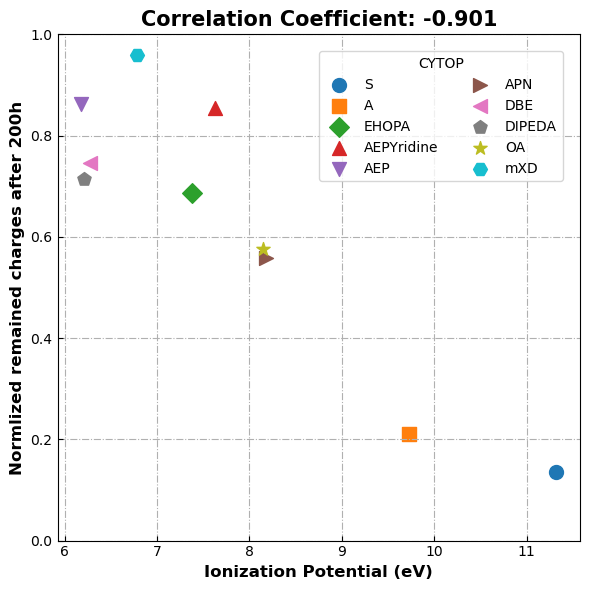

In [220]:
plt.rcdefaults()

def draw_corrcoef(x, y, title='Correlation Coefficient'):
    # 示例形状和标签
    shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']
    labels = [f'{name_list[i]}' for i in range(len(x))]
    co = round(np.corrcoef(x, y)[0,1],3)
    # 创建散点图并指定不同的形状和标签
    plt.figure(figsize=(6, 6))
    plt.tick_params(axis='both', direction='in', which='both')
    plt.grid(linestyle='-.')
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker=shapes[i], label=labels[i], s=100)  # 每个点的形状和标签
    # 添加图例
    plt.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), ncol=2, title="CYTOP")
    # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
    # 设置图形标题和坐标轴标签
    plt.title(f"Correlation Coefficient: {co}",fontsize=15,fontweight='bold')
    plt.xlabel("Ionization Potential (eV)",fontsize=12,fontweight='bold')
    plt.xticks(fontsize=10)  # X轴刻度字体大小
    plt.yticks(fontsize=10) 
    plt.ylabel("Normlized remained charges after 200h",fontsize=12,fontweight='bold')
    plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(title,dpi=300)
    # 显示图形
    plt.show()
    
draw_corrcoef(ip_pcm,psp,title='IPPCM_MAO')

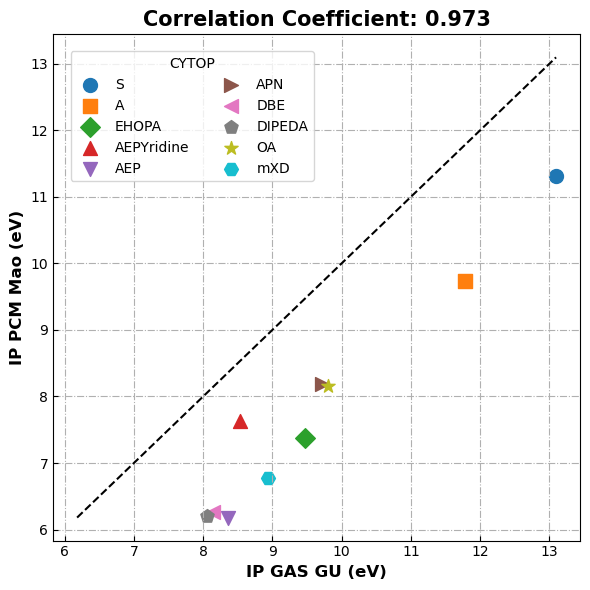

In [236]:
plt.rcdefaults()

def draw_corrcoef(x, y, title='Correlation Coefficient'):
    # 示例形状和标签
    shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']
    labels = [f'{name_list[i]}' for i in range(len(x))]
    co = round(np.corrcoef(x, y)[0,1],3)
    # 创建散点图并指定不同的形状和标签
    plt.figure(figsize=(6, 6))
    plt.tick_params(axis='both', direction='in', which='both')
    plt.plot([min(min(x),min(y)),max(max(x),max(y))],[min(min(x),min(y)),max(max(x),max(y))],linestyle='--',color='black')
    plt.grid(linestyle='-.')
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker=shapes[i], label=labels[i], s=100)  # 每个点的形状和标签
    # 添加图例
    plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")
    # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
    # 设置图形标题和坐标轴标签
    plt.title(f"Correlation Coefficient: {co}",fontsize=15,fontweight='bold')
    plt.xlabel("IP GAS GU (eV)",fontsize=12,fontweight='bold')
    plt.xticks(fontsize=10)  # X轴刻度字体大小
    plt.yticks(fontsize=10) 
    plt.ylabel("IP PCM Mao (eV)",fontsize=12,fontweight='bold')
    plt.tight_layout()
    plt.savefig(title,dpi=300)
    # 显示图形
    plt.show()
    
draw_corrcoef(mean,ip_pcm,title='Mao_VS_GU')

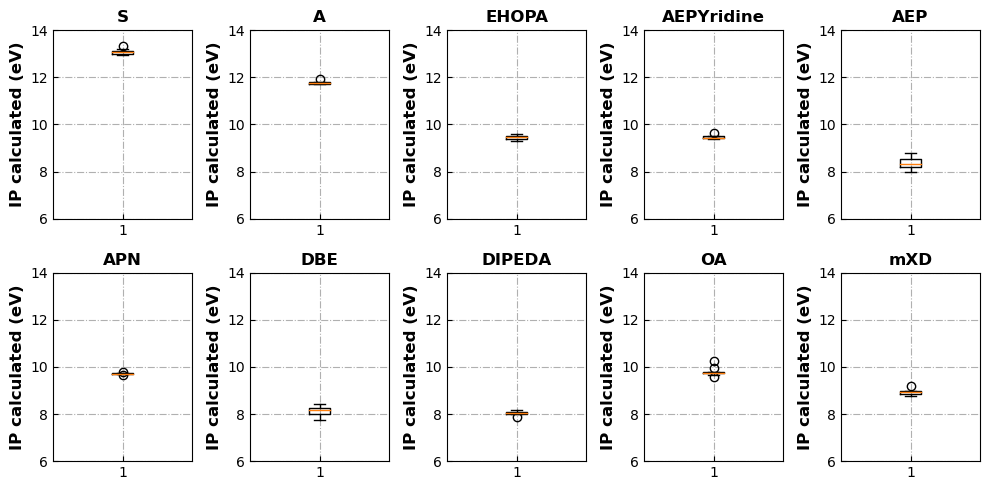

In [246]:

# 示例数据，替换为你的IP值数据
# 统计描述

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.boxplot(rdkit_df.iloc[:,i], vert=True)  # 绘制箱型图
    ax.set_ylabel('IP calculated (eV)',fontsize=12,fontweight='bold')
    ax.grid(linestyle='-.')
    ax.tick_params(axis='both', direction='in')  # 'both'表示x和y轴都调整
    ax.set_ylim(6,14)
    ax.set_title(f'{name_list[i]}',fontsize=12,fontweight='bold')
plt.tight_layout()
plt.savefig('CYTOP_m062x_6-311G(2d_p)_IP_rdkit.png', dpi=300)

plt.show()


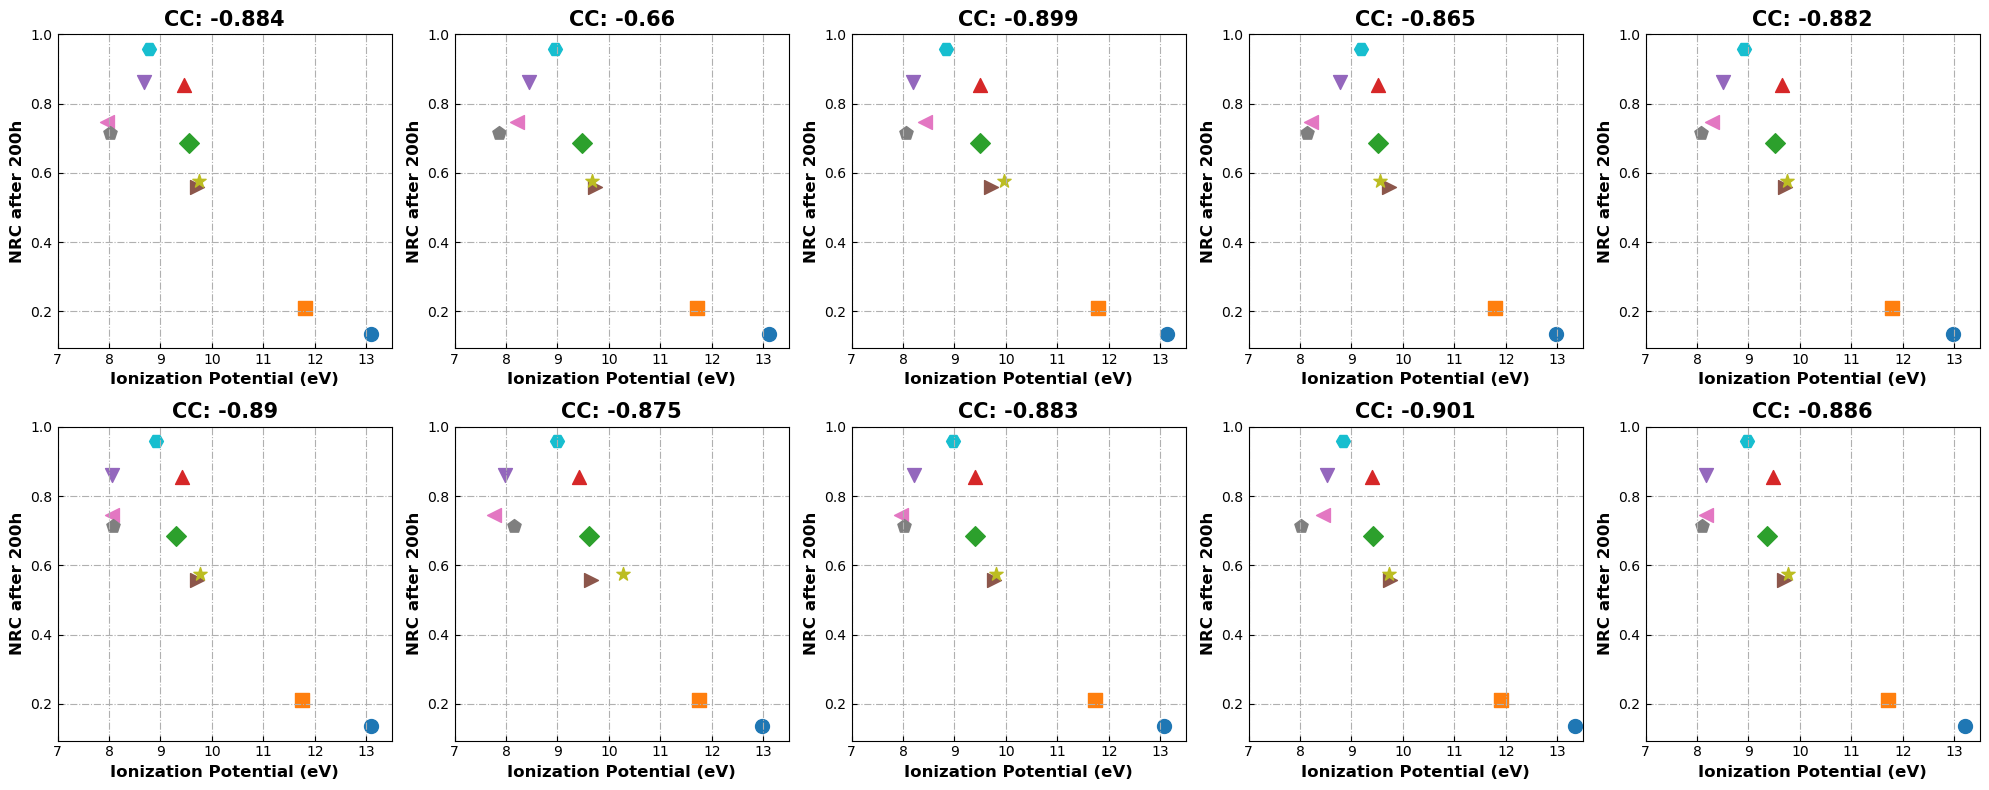

<Figure size 640x480 with 0 Axes>

In [239]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# 示例形状和标签
shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']

for j, ax in enumerate(axes.ravel()):
    if j < len(name_list):
        # 创建散点图并指定不同的形状和标签
        shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']
        labels = [f'{name_list[i]}' for i in range(10)]
        co = round(np.corrcoef(rdkit_df.iloc[j,:], psp)[0,1],3)
        # 创建散点图并指定不同的形状和标签
        ax.tick_params(axis='both', direction='in', which='both')
        ax.grid(linestyle='-.')
        for i in range(10):
            ax.scatter(rdkit_df.iloc[j,:][i], psp[i], marker=shapes[i], label=labels[i], s=100)  # 每个点的形状和标签
        # 添加图例
        # plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")
        # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
        # 设置图形标题和坐标轴标签
        ax.set_title(f"CC: {co}",fontsize=15,fontweight='bold')
        ax.set_xlabel("Ionization Potential (eV)",fontsize=12,fontweight='bold')     
        ax.tick_params(axis='both', direction='in', which='both')
        ax.set_xlim(7,13.5)
        ax.set_ylabel("NRC after 200h",fontsize=12,fontweight='bold')
plt.tight_layout()
# 显示图形
plt.savefig('random.png',dpi=300)
plt.show()

# 调整子图之间的间距
plt.tight_layout()

In [ ]:
def time_calculation(log):
    with open(log, 'r') as file:
        for line in file:
            if "Job cpu time" in line:
                cpu_time = line.split(":")[1].strip()  # 获取冒号后面的部分并去除首尾空格
                day = cpu_time.split()[0]
                hour = cpu_time.split()[2]
                min = cpu_time.split()[4]
                sec = cpu_time.split()[6]
                cpu_time = int(day) * 24 * 60 + int(hour) * 60 + int(min)  + float(sec)/60
                return cpu_time

In [59]:
T1,T2,T_all = [],[],[]
time_dict = {}
for _ in name_list:
    for i in range(200):
        if os.path.exists(f"{_}{i}"):
            t1 = time_calculation(f"{_}{i}/{_}{i}_p1.log")
            t2 = time_calculation(f"{_}{i}/{_}{i}_0.log")
            T1.append(t1)
            T2.append(t2)
            T_all.append(t1+t2)
table = pd.DataFrame({'Name': IP_name, 'Tp': t1,'Tn':t2,'T':T_all})
pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.width', None)  # 显示完整行宽度
table.to_csv('CYTOP_m062x_6-311G(2d,p)_time.csv', index=False)# max(time)
rdkit_df = pd.read_csv('CYTOP_m062x_6-311G(2d,p)_IP_rdkit.csv')


**RMSD Analysis**

In [81]:
#RMSD
names = locals()
for k in tqdm(range(len(name_list))):

    names['rdkit_'+ name_list[k]] = pd.DataFrame(np.zeros((10, 10)))
    for i in tqdm(range(10)):
        for j in range(i):
            output = os.popen((f'calculate_rmsd {name_list[k]}{i}/{name_list[k]}{i}_0.xyz {name_list[k]}{j}/{name_list[k]}{j}_0.xyz')).read()
            sim = round(float(output.split()[0]),3)
            names['rdkit_'+ name_list[k]].iloc[i, j]= sim
            names['rdkit_'+ name_list[k]].iloc[j,i] = sim
    names['rdkit_'+ name_list[k]].to_csv(f'rdkit_{name_list[k]}.csv')


    # geomol_s

100%|██████████| 10/10 [00:00<00:00, 600.80it/s]


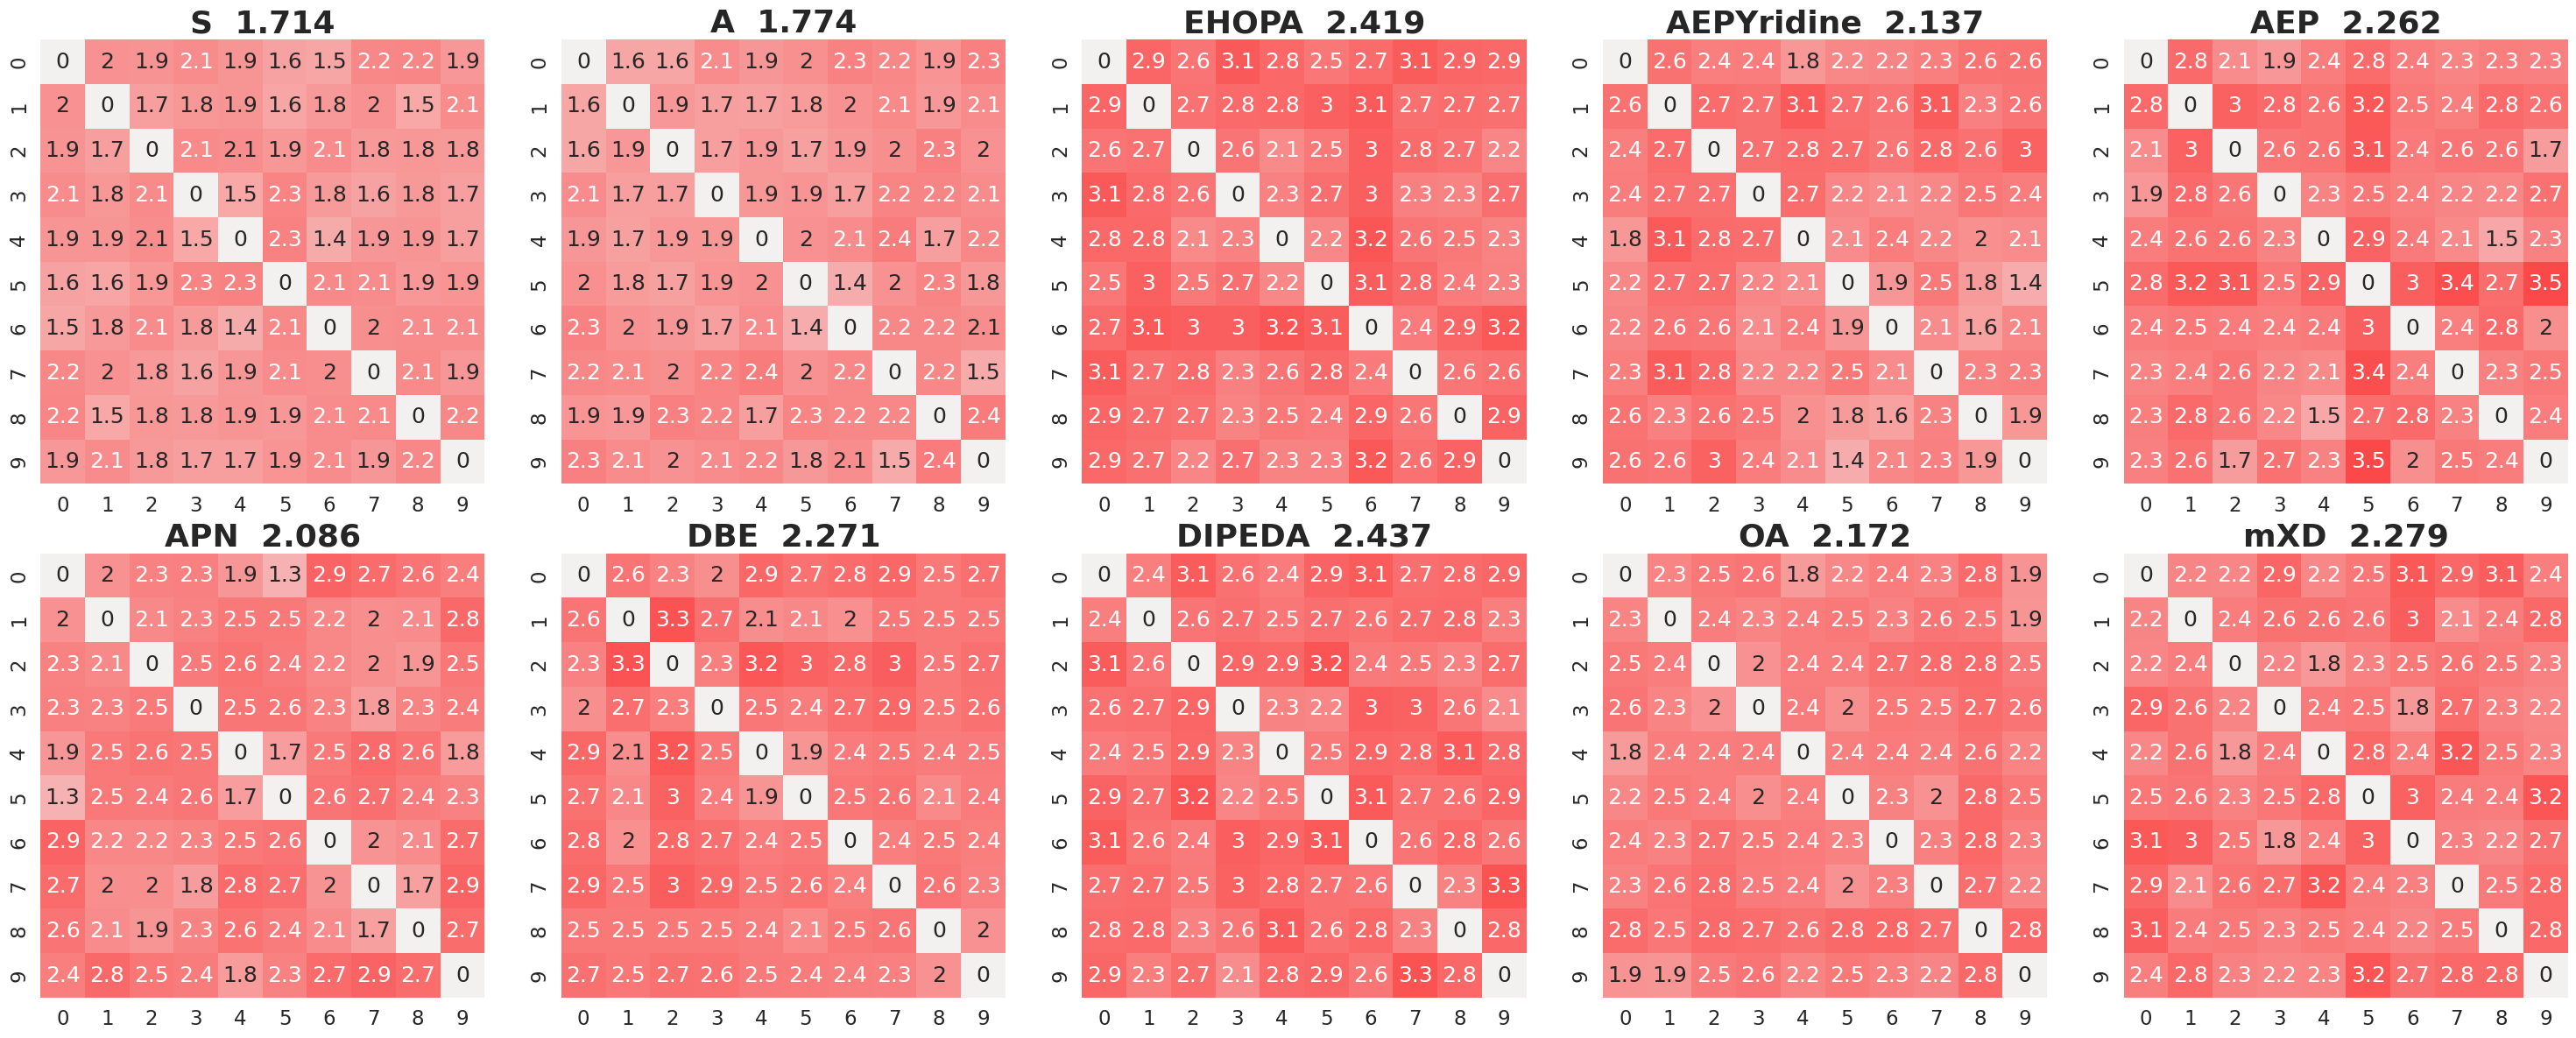

In [124]:
fig, axes = plt.subplots(2, 5, figsize=(30, 12))

# 用于设置渐变色图的参数
cm = sns.light_palette("red", as_cmap=True)
vmin, vmax = 0, 5
for i, ax in enumerate(axes.ravel()):
    if i < len(name_list):
        sns.set(font_scale=1.5)
        sns.heatmap(names['rdkit_'+ name_list[i]], cmap=cm, annot=True, vmin=vmin, vmax=vmax, square=True, cbar=False, ax=ax)
        x = round(names['rdkit_'+ name_list[i]].mean().mean(),3)
        ax.set_title(f'{name_list[i]}  {x}'  ,fontsize=26,fontweight="bold")
    else:
        ax.axis('off')  # 隐藏多余的子图

# 调整子图之间的间距
plt.tight_layout()

plt.savefig('CYTOP_rdkit_rmsd.png', dpi=300)
plt.show()

In [92]:
names = locals()
for k in tqdm(range(len(name_list))):
    names['geomol_'+ name_list[k]] = pd.DataFrame(np.zeros((10, 10)))
    m, n = -1,-1
    for i in range(200):
        if os.path.exists(f"/home/k0335/k033513/electret_cal_git_cytop_ip_geomol/{name_list[k]}{i}/{name_list[k]}{i}_0.xyz"):
            m += 1
            n = -1
            for j in range(i):
                if os.path.exists(f"/home/k0335/k033513/electret_cal_git_cytop_ip_geomol/{name_list[k]}{j}/{name_list[k]}{j}_0.xyz"):
                    n += 1
                    output = os.popen((f'calculate_rmsd /home/k0335/k033513/electret_cal_git_cytop_ip_geomol/{name_list[k]}{i}/{name_list[k]}{i}_0.xyz /home/k0335/k033513/electret_cal_git_cytop_ip_geomol/{name_list[k]}{j}/{name_list[k]}{j}_0.xyz')).read()
                    sim = round(float(output.split()[0]),3)
                    names['geomol_'+ name_list[k]].iloc[m,n]= sim
                    names['geomol_'+ name_list[k]].iloc[n,m] = sim
    names['geomol_'+ name_list[k]].to_csv(f'geomol_{name_list[k]}.csv')


100%|██████████| 10/10 [04:13<00:00, 25.34s/it]


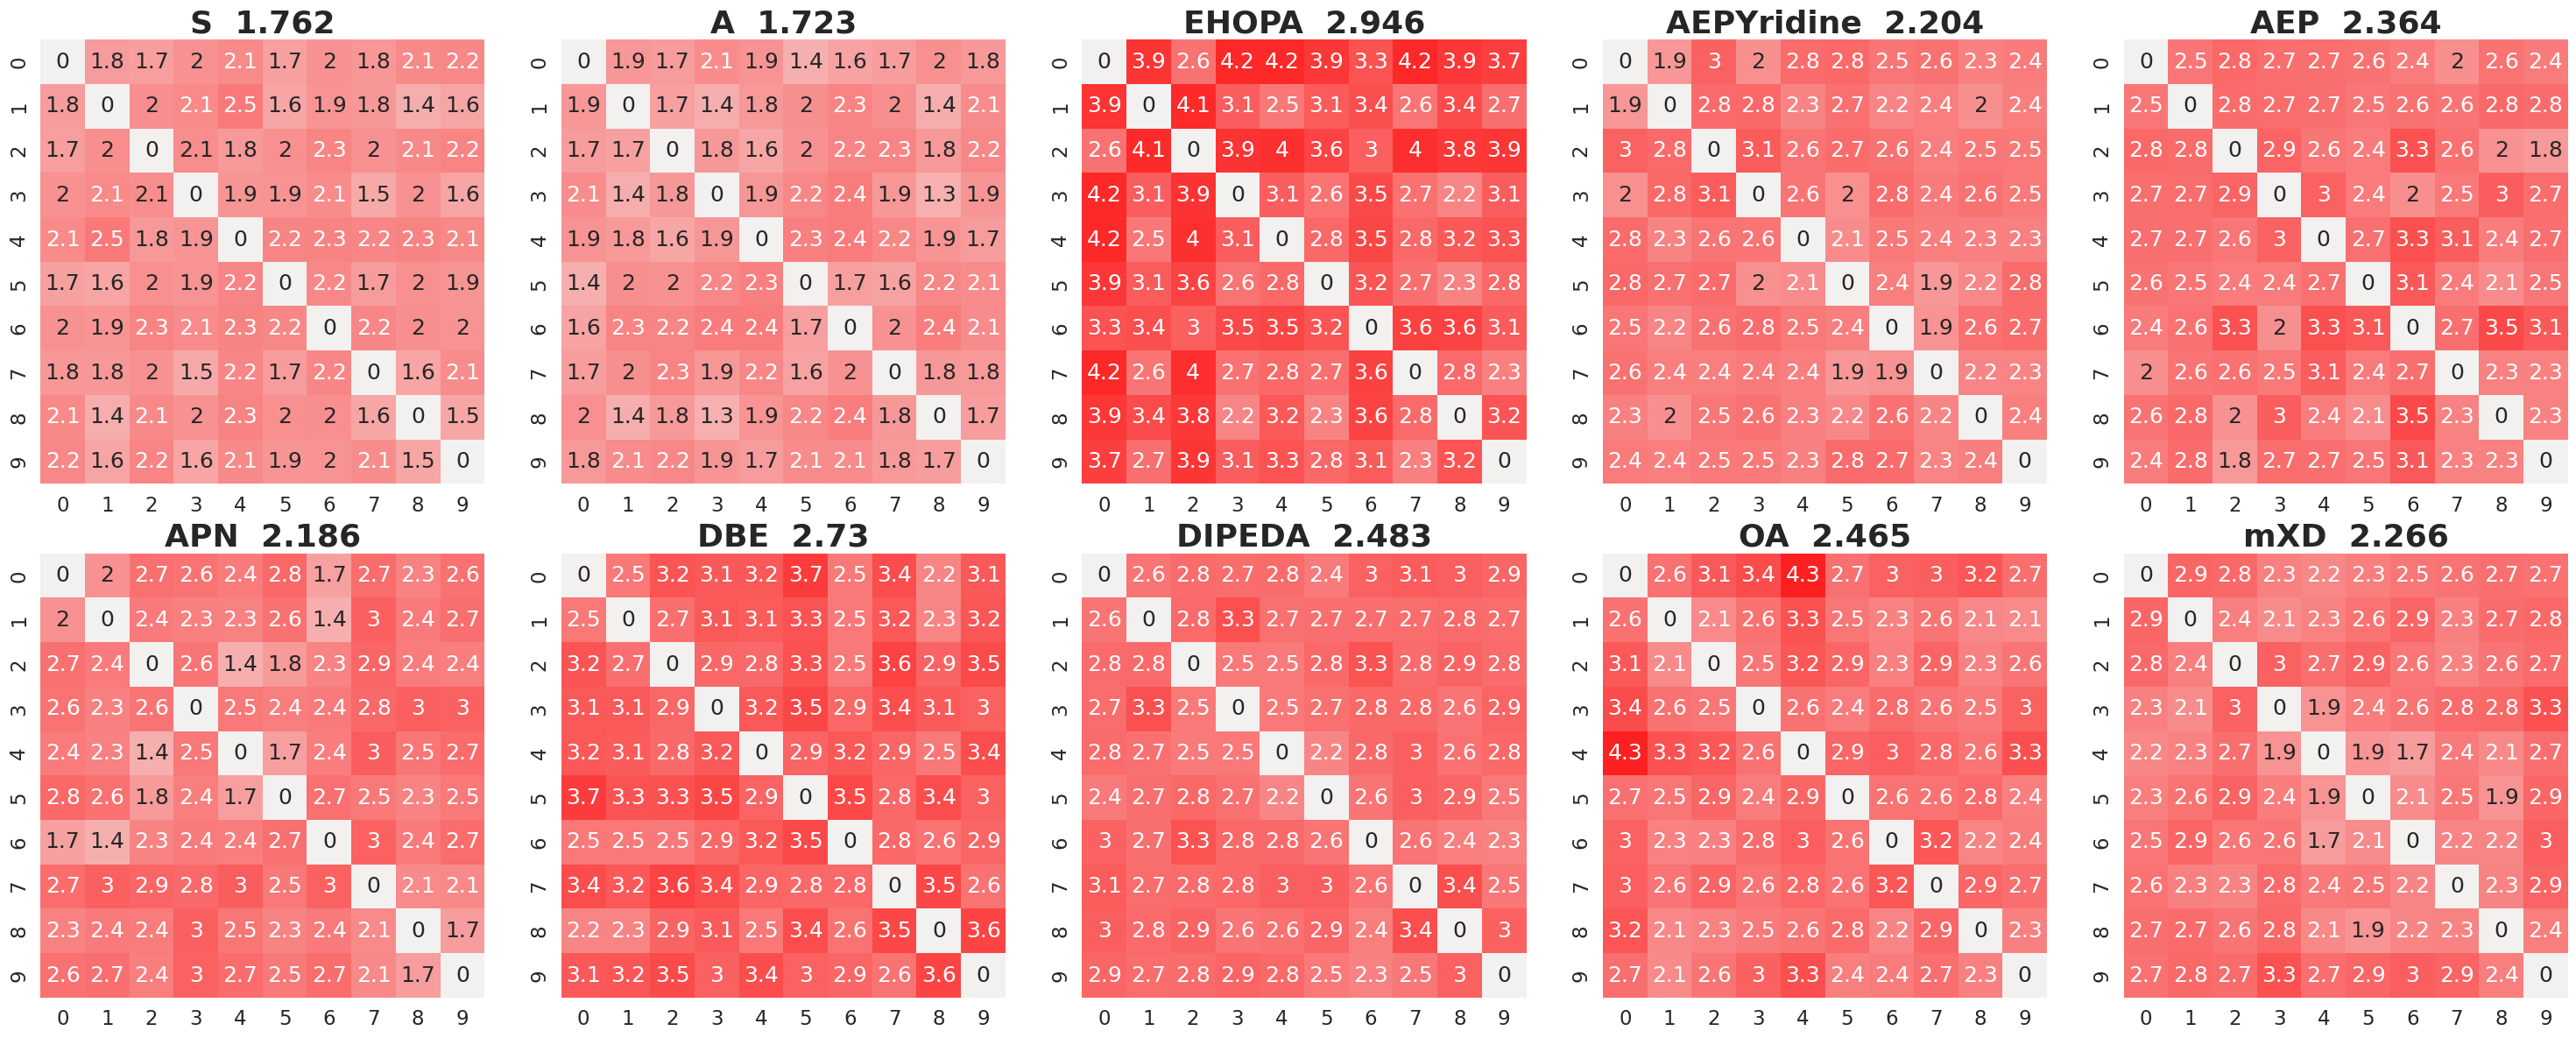

In [123]:
fig, axes = plt.subplots(2, 5, figsize=(30, 12))

# 用于设置渐变色图的参数
cm = sns.light_palette("red", as_cmap=True)
vmin, vmax = 0, 5
for i, ax in enumerate(axes.ravel()):
    if i < len(name_list):
        sns.set(font_scale=1.5)
        sns.heatmap(names['geomol_'+ name_list[i]],cmap=cm, annot=True, vmin=vmin, vmax=vmax, square=True, cbar=False, ax=ax)
        x = round(names['geomol_'+ name_list[i]].mean().mean(),3)
        ax.set_title(f'{name_list[i]}  {x}'  ,fontsize=26,fontweight="bold")
    else:
        ax.axis('off')  # 隐藏多余的子图

# 调整子图之间的间距
plt.tight_layout()

plt.savefig('CYTOP_geomol_rmsd.png', dpi=300)
plt.show()